In [1]:
# Newer attempt to make it quicker
# Get the envelope only on the segments where rms is significant.

# viewing neural data
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.signal import hilbert
from scipy.stats import pearsonr
from scipy.io import wavfile
from scipy.signal import spectrogram
from basic_viewing import h5_functions as h5
import logging
import threading
from IPython.display import display

class chunkFunction():
    def __init__(self, chunk, function, *args, **kwargs):
        print args
        self.chunk = chunk
        self.func = function
        self.args = args
        self.kwargs = kwargs

    def start(self):
        display('Starting function {0}'.format(self.func.func_name))
        for arg in self.args:
            print arg
        for key, arg in self.kwargs.iteritems():
            print key
            print arg
        self.chunk.apply_filter(self.func, *self.args, **self.kwargs)
        print "done"

class threadFunction():
    def __init__(self, function, *args, **kwargs):
        self.func = function
        self.args = args
        self.kwargs = kwargs
        self.out = None

    def run(self):
        display('Starting function {0}'.format(self.func.func_name))
        for arg in self.args:
            print arg
        for key, arg in self.kwargs.iteritems():
            print key
            print arg
        self.out = self.func(*self.args, **self.kwargs)
        print "done"
matplotlib.style.use('ggplot')


# Check wihic computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name
if  comp_name == 'chim':
    #sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join(os.path.abspath('W:') , "earneodo", "bci_zf")
elif  'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/reposs')
    experiment_folder = os.path.join(os.path.abspath('/Volumes') , 'gentner', 'earneodo', 'bci_zf')

elif 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

elif 'passaro' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'analysis-tools'))

import soundtools as st
import Kwik as oe


raw_data_folder = os.path.join(experiment_folder, 'raw_data')
ss_data_folder = os.path.join(experiment_folder, 'ss_data')

Computer: passaro


In [27]:
#file structure
bird_id = 'z020'
sess = 'day-2016-06-02'
rec = 3
run = 1
processor = ''
pattern = 1
chan_name = "CH17"
chan_number = 16


raw_file_folder = os.path.join(ss_data_folder, bird_id, sess)
raw_file_base_name = 'experiment'

raw_file_name = raw_file_base_name + processor + '.raw.kwd'
evt_file_name = raw_file_base_name + '.kwe'
mot_file_name = raw_file_base_name + '.sng.kwe'

raw_file_path = os.path.join(raw_file_folder, raw_file_name)
evt_file_path = os.path.join(raw_file_folder, evt_file_name)
mot_file_path = os.path.join(raw_file_folder, mot_file_name)

# open the file in read mode
raw_file = h5py.File(raw_file_path, 'r')
#evt_file = h5py.File(evt_file_path, 'r')

# load it with the open-ephys api for version 2 of kiwk format

oe_file = oe.load(raw_file_path)
raw_file['recordings'].keys()

[u'0', u'1', u'2', u'3', u'4', u'5']

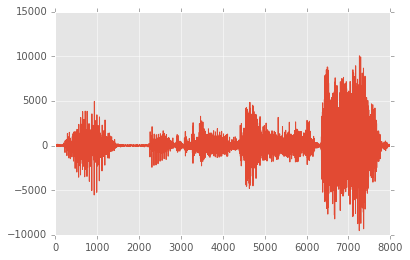

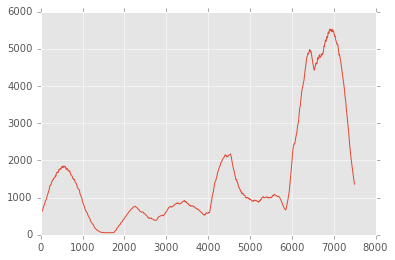

In [28]:
# get the sound and the pattern

data_table = raw_file['/recordings'][str(rec)]['data']
chan_sf = oe.get_sample_rate(raw_file)

#filter parameters
filt_lo = 7000 #Hz
filt_hi = 500 #Hz

# sonogram parameters
n_window = 256;
n_overlap = 192;
f_cut = 10000;
sigma = 1./1000.*chan_sf

#template match parameters
window_env = 500

audio_slice = h5.load_table_slice(data_table, np.arange(0, data_table.shape[0]), [chan_number])
# chan_sound = st.DatSoundCompat(st.bandpass_filter(audio_slice[int(3674.214226*30000.) - 16000:
#                                                               int(3674.214226*30000.)+320000,0], chan_sf, filt_hi, filt_lo), 
#                                                   chan_sf, data_type=np.float)
#chan_whole_sound = st.DatSoundCompat(st.bandpass_filter(audio_slice[:,0], chan_sf, filt_hi, filt_lo),
#                                     chan_sf, data_type=np.float)
                               
# # Now try to save a channel as a wav file
# from scipy.io import wavfile
out_file_name = raw_file_base_name +  '_' + chan_name + 'song.wav'
# wavfile.write(os.path.join(raw_file_folder, out_file_name),chan_sf, np.array(chan_sound.stream, dtype='int16'))

#make the filter for the data file
s_f = chan_sf
#The band where we expect most of the energy of zf song to be in
hp_b, hp_a = sg.butter(4, filt_hi/(s_f/2.), btype='high')
lp_b, lp_a = sg.butter(4, filt_lo/(s_f/2.), btype='low')

# read a bout from a wave file and prepare the templates 
pattern_name = 'motiff_' + str(pattern) + '.wav'
pattern_path = os.path.join(raw_file_folder, pattern_name)

pattern_sound = st.WavData2(pattern_path)
pattern_chunk = st.Chunk(pattern_sound)
pattern_chunk.apply_filter(st.bandpass_filter, s_f)
plt.plot((pattern_chunk.data))
pattern_envelope = st.envelope(pattern_chunk.data[:,0], window=window_env)
plt.figure()
plt.plot(pattern_envelope)
pattern_spectrogram = spectrogram(pattern_chunk.data[:,0], s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
plt.figure()


In [29]:
# create logger with 'spam_application'
logger = logging.getLogger('searching_motiff_nopandas')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('search_motiff-v2-unified.log')
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

spectrogram_diff = st.spectrogram_diff
spectrogram_scores = st.spectrogram_scores
cluster_spectrograms = st.cluster_spectrograms
rms = st.rms

def find_happy_song(chan_sound, pattern_chunk):
    window_env = 500
    rms_thresh = 1.
    onset_resolution = 1
    rolling_method = 'pandas'
    logger.info('Begin to search')
    envelope_matches = st.match_by_envelope(chan_sound, pattern_chunk, 
                                             window_size=window_env, 
                                             rms_threshold=rms_thresh,
                                             window_step=onset_resolution, 
                                            rolling_method=rolling_method)
    
    offset = pattern_chunk.samples if rolling_method is 'pandas' else 0
    candidates = pd.DataFrame({'start' : (envelope_matches['peaks'] + 1) * onset_resolution - offset,
                           'env_corr': envelope_matches['corr'][envelope_matches['peaks']],
                           'spectral_diff': np.zeros_like(envelope_matches['peaks'], dtype=np.float)})
    
    n_candidates = len(candidates.index)
    logger.info('Found {0} candidates'.format(n_candidates))
    
    if n_candidates > 0:
        logger.info('Getting spectrogram scores')
        spectrogram_scores(pattern_chunk, chan_sound, candidates)
        if n_candidates > 2:
            logger.info('Clustering candidates')
            cluster_spectrograms(candidates)
    else:
        pass
    logger.debug('Returning clustered candidates')
    return candidates

chan_sound = st.DatSoundCompat(st.bandpass_filter(audio_slice[:,0], chan_sf, filt_hi, filt_lo),
                                     chan_sf, data_type=np.float)

# chan_sound = st.DatSoundCompat(st.bandpass_filter(audio_slice[int(3674.214226*30000.) - 16000:
#                                                               int(3674.214226*30000.) + 300000,0], 
#                                                   chan_sf, filt_hi, filt_lo), 
#                                                   chan_sf, data_type=np.float)
task_find_happy_song = threadFunction(find_happy_song, chan_sound, pattern_chunk)

threads = []
t = threading.Thread(name= 'task_find_happy_song', 
                     target=task_find_happy_song.run)
threads.append(t)
t.start()

'Starting function find_happy_song'

2016-07-08 15:25:45,661 - searching_motiff_nopandas - INFO - Begin to search


<soundtools.DatSoundCompat instance at 0x7fb6bc088710>
<soundtools.Chunk instance at 0x7fb813bac5f0>


2016-07-08 15:25:45,661 - searching_motiff_nopandas - INFO - Begin to search


In [71]:
t.isAlive()

False

In [72]:
#result = task_find_happy_song.out
all_candidates = result[result['bout']==True].sort_values('spectral_diff').reset_index()
all_candidates

,index,env_corr,spectral_diff,start,bout
0,3,0.973263,0.403615,16906540,True
1,33,0.919229,0.407049,16818563,True
2,56,0.904159,0.415600,44249656,True
3,1,0.974804,0.416665,16802670,True
4,0,0.979471,0.419226,16834015,True
5,2,0.974586,0.429007,16845169,True
6,152,0.855803,0.435682,44280036,True
7,65,0.890589,0.436162,67999250,True
8,13,0.929438,0.438282,44264842,True
9,74,0.884741,0.438397,44329617,True


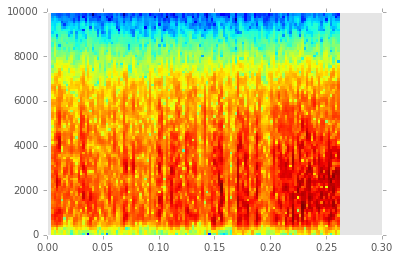

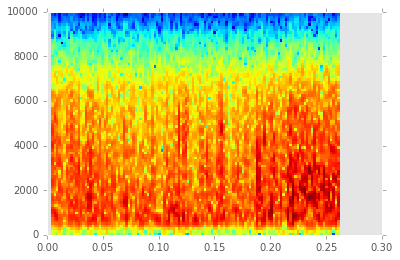

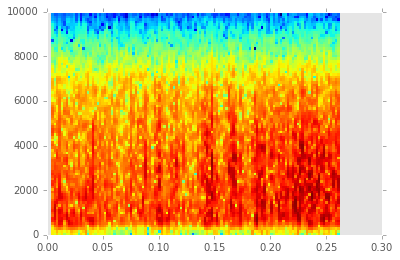

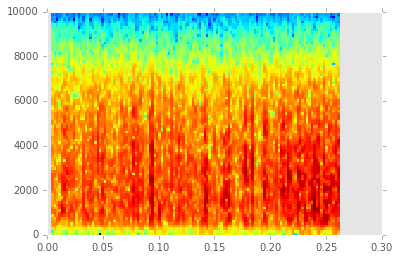

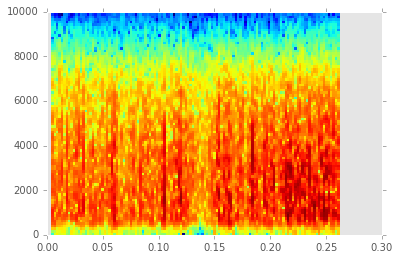

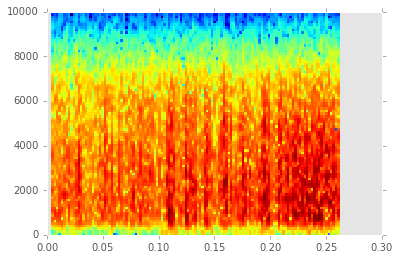

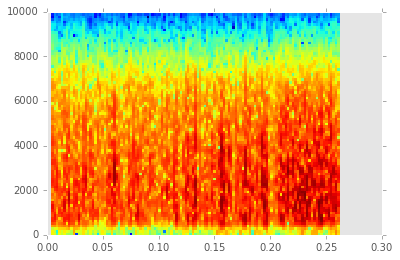

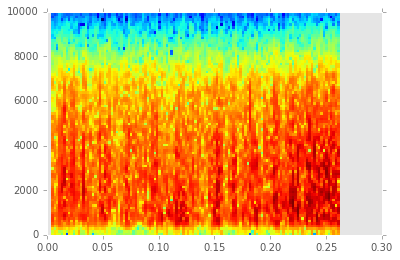

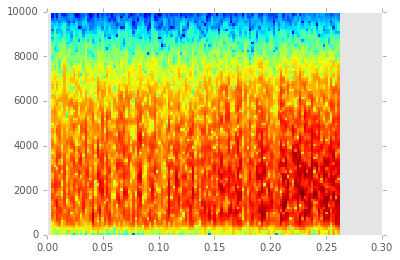

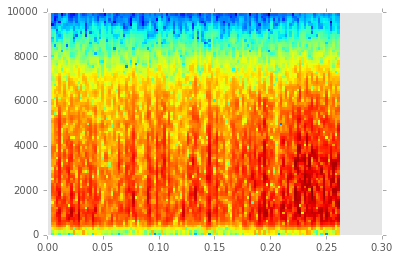

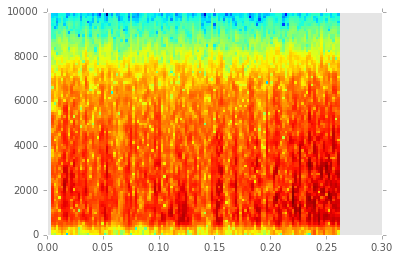

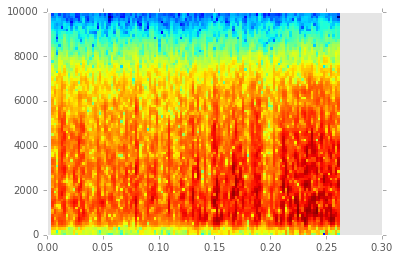

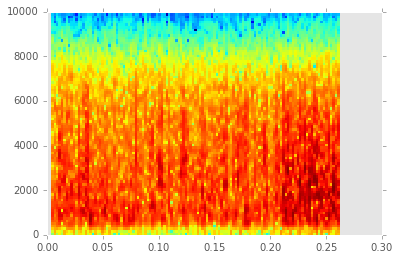

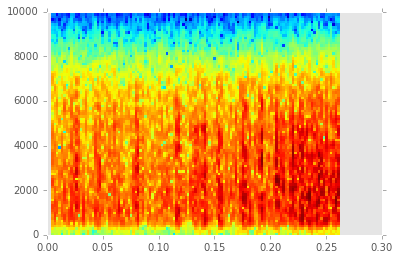

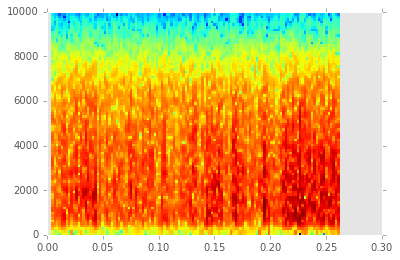

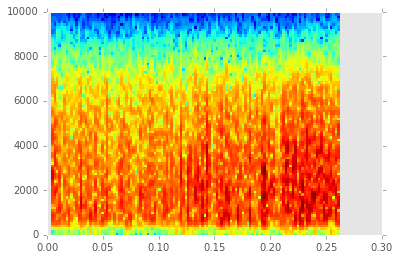

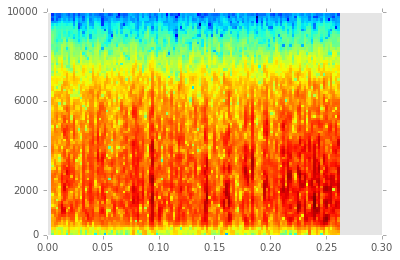

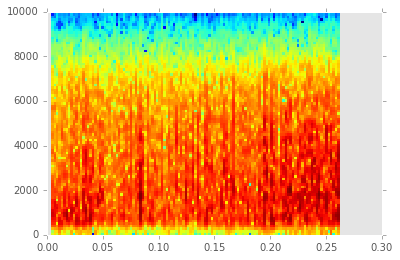

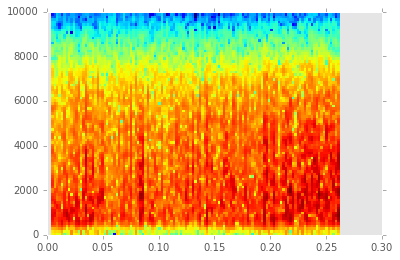

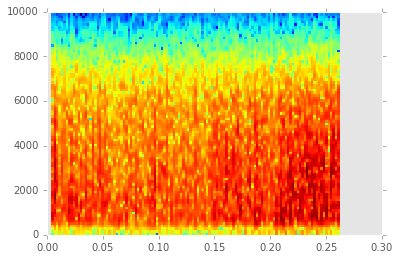

In [75]:
first_to_plot = 0
plot_as_many = 20

spectrogram_kwargs = {'nperseg': n_window,
                    'noverlap': n_overlap,
                    'window': sg.gaussian(n_window, sigma),
                    'scaling': 'spectrum'}

result = task_find_happy_song.out
all_candidates = result[result['bout']==True].sort_values('spectral_diff').reset_index()
rms_thresh = 0.;

for (i, start) in enumerate(all_candidates['start'][first_to_plot: first_to_plot 
                                                    + plot_as_many]):
    motif_start = start
    #print all_candidates[i]
    series = chan_sound.get_chunk(motif_start, motif_start + pattern_chunk.samples)
    # get the histogram
    f, t, sxx = spectrogram(series[0, :], s_f, **spectrogram_kwargs)
    # get the rms
    #print rms(st.bandpass_filter(series[:, 0], s_f))
    all_candidates.set_value(i, 'rms', st.rms(st.bandpass_filter(series[0,:], s_f)))
    plt.figure()
    plt.pcolormesh(t, f[f < f_cut], np.log(sxx[f < f_cut, :]))

all_candidates = all_candidates[all_candidates['rms'] > rms_thresh].reset_index()

In [74]:
all_candidates
all_starts = all_candidates['start'].values
all_starts

array([16906540, 16818563, 44249656, 16802670, 16834015, 16845169,
       44280036, 67999250, 44264842, 44329617, 44291291,  7873748,
       58833929, 12537412, 58833923, 11877017,  2475712,  4565887,
       62492272, 67523607, 67523613, 58850261, 16783466, 67523627,
       26645816, 67523634])

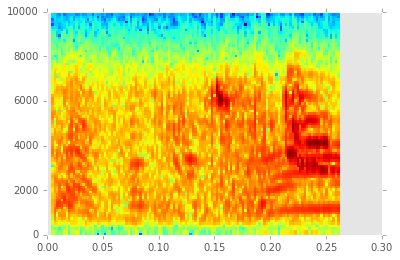

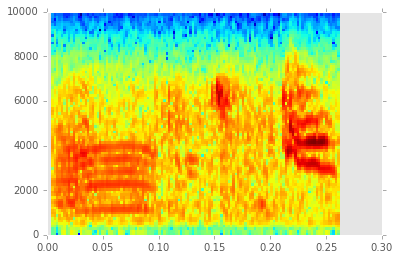

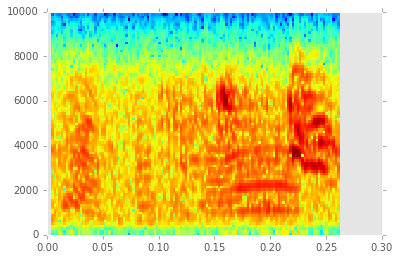

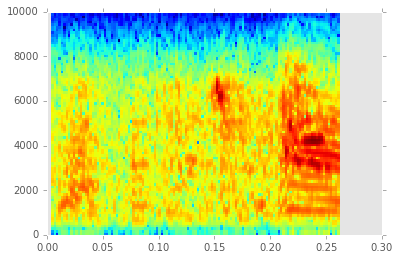

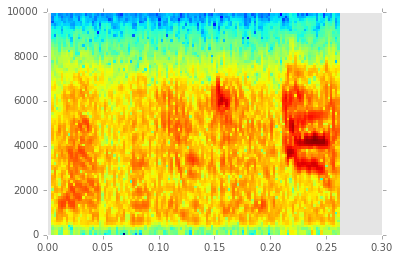

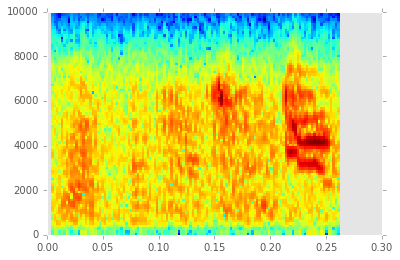

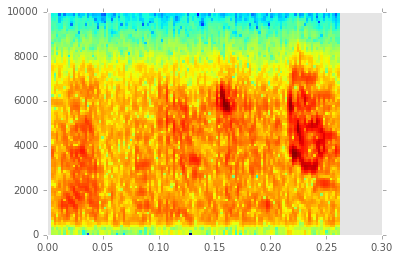

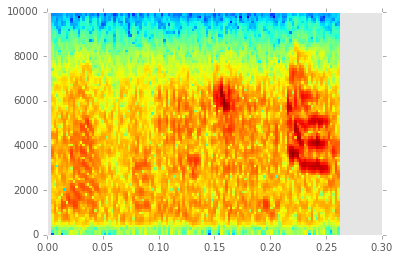

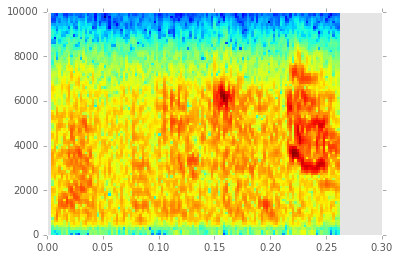

In [24]:
cut = 19

store_starts = np.concatenate([all_candidates['start'].values[0:7],
                         all_candidates['start'].values[8:10]])
store_starts

#confirm starting points
for start in store_starts:
    motif_start = start
    #print all_candidates[i]
    series = chan_sound.get_chunk(motif_start, motif_start + pattern_chunk.samples)
    # get the histogram
    f, t, sxx = spectrogram(series[0, :], s_f, **spectrogram_kwargs)
    # get the rms
    plt.figure()
    plt.pcolormesh(t, f[f < f_cut], np.log(sxx[f < f_cut, :]))

In [26]:
# Save in the file
def append_rows(table, new_data):
    rows = table.shape[0]
    more_rows = new_data.shape[0]
    table.resize(rows + more_rows, axis=0)
    if table.size == (rows + more_rows):
        table[rows:] = new_data
    else:
        table[rows:,:] = new_data

def unlimited_rows_data(group, table_name, data):
    try:
        table = group.create_dataset(table_name, data=data, dtype=data.dtype, maxshape={None, None})
    except RuntimeError as e:
        if 'Name already exists' in str(e):
            table = group[table_name]
            append_rows(table, data)
        else:
            raise
    return table

def store_motiff(ev_file, rec, bout_starts, motiff_name):
    motiff_group = ev_file.require_group('/event_types/singing/{0}'.format(motiff_name))
    t_table = unlimited_rows_data(motiff_group, 'time_samples', bout_starts)
    r_table = unlimited_rows_data(motiff_group, 'recording', data=np.ones_like(bout_starts)*int(rec))
    

mot_file_name = raw_file_base_name + '.sng.kwe'
mot_file_path = os.path.join(raw_file_folder, mot_file_name)    

mot_file = h5py.File(mot_file_path, 'a')
store_motiff(mot_file, rec, store_starts, 'motiff_1')
mot_file.close()

2